<a href="https://colab.research.google.com/github/yapanits111/naiveBayesSpamFilter/blob/main/Naive_Bayes_Spam_filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Uploading file
import zipfile
import os

# Unzipping the file
with zipfile.ZipFile('/trec06p-cs280.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/trec06p')

In [ ]:
!pwd

/content


In [ ]:
!pip install wordcloud
from wordcloud import WordCloud

In [ ]:
# NAIVE BAYES SPAM FILTER
# For TREC06 Dataset

# --- SETUP ---
import os
import re
import math
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

# --- FUNCTIONS ---

def parse_labels(label_file):
    labels = {}
    with open(label_file, 'r') as f:
        for line in f:
            label, path = line.strip().split()
            normalized_path = os.path.normpath(path).split('data/')[-1]  # Get just '000/001'
            labels[normalized_path] = 1 if label == 'ham' else 0
    return labels

def parse_emails(folder_path, labels):
    docs = []
    for root, dirs, files in os.walk(folder_path):
        for filename in files:
            if filename.startswith('.'):
                continue
            file_path = os.path.join(root, filename)
            rel_path = os.path.relpath(file_path, folder_path)
            if rel_path in labels:
                with open(file_path, 'r', encoding='latin-1') as file:
                    content = file.read()
                    words = re.findall(r'[a-zA-Z]+', content.lower())
                    docs.append((rel_path, words, labels[rel_path]))
    return pd.DataFrame(docs, columns=['doc_id', 'message', 'label'])

class NaiveBayesClassifier:
    def __init__(self, lambda_value=1.0):
        self.lambda_value = lambda_value
        self.vocab = set()
        self.word_counts = {0: defaultdict(int), 1: defaultdict(int)}
        self.total_words = {0: 0, 1: 0}
        self.priors = {0: 0.0, 1: 0.0}

    def train(self, df):
        spam_docs = df[df['label'] == 0]
        ham_docs = df[df['label'] == 1]

        self.priors[0] = len(spam_docs) / len(df)
        self.priors[1] = len(ham_docs) / len(df)

        for _, row in df.iterrows():
            label = row['label']
            for word in row['message']:
                self.vocab.add(word)
                self.word_counts[label][word] += 1
                self.total_words[label] += 1

    def predict(self, words):
        scores = {}
        vocab_size = len(self.vocab)

        for label in [0,1]:
            log_prob = math.log(self.priors[label])
            for word in words:
                word_count = self.word_counts[label].get(word, 0)
                log_prob += math.log((word_count + self.lambda_value) / (self.total_words[label] + self.lambda_value * vocab_size))
            scores[label] = log_prob

        return max(scores, key=scores.get)

    def evaluate(self, df):
        TP = TN = FP = FN = 0

        for _, row in df.iterrows():
            pred = self.predict(row['message'])
            true = row['label']

            if pred == 0 and true == 0:
                TP += 1
            elif pred == 1 and true == 1:
                TN += 1
            elif pred == 0 and true == 1:
                FP += 1
            elif pred == 1 and true == 0:
                FN += 1

        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0

        return precision, recall

def test_lambdas(train_df, test_df, lambdas=[2.0, 1.0, 0.5, 0.1, 0.005]):
    results = []
    for l in lambdas:
        model = NaiveBayesClassifier(lambda_value=l)
        model.train(train_df)
        precision, recall = model.evaluate(test_df)
        print(f"Lambda={l:.3f}: Precision={precision:.4f}, Recall={recall:.4f}")
        results.append((l, precision, recall))
    return results

def find_most_informative_words(classifier, top_n=200):
    informative = {}
    for word in classifier.vocab:
        spam_count = classifier.word_counts[0].get(word, 0)
        ham_count = classifier.word_counts[1].get(word, 0)
        if spam_count + ham_count > 0:
            llr = math.log((spam_count + 1) / (ham_count + 1))
            informative[word] = abs(llr)

    sorted_words = sorted(informative.items(), key=lambda x: x[1], reverse=True)
    return [word for word, score in sorted_words[:top_n]]

def generate_wordcloud(df, label, title):
    text = ' '.join([' '.join(words) for words in df[df['label'] == label]['message']])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()



 Total emails loaded: 37822
Label counts:
label
Spam (0)    24912
Ham (1)     12910
Name: count, dtype: int64

 Sample loaded emails:
    doc_id  label
0  000/011      0
1  000/126      1
2  000/167      0
3  000/263      1
4  000/018      0

 Training Set Label Distribution:
label
Spam (0)    14947
Ham (1)      7746
Name: count, dtype: int64

 Test Set Label Distribution:
label
Spam (0)    9965
Ham (1)     5164
Name: count, dtype: int64

 Training final model with best lambda (λ = 0.005)...
 Final Model Performance:
   - Precision: 0.9891
   - Recall   : 0.9877

 Testing different lambda values:
Lambda=2.000: Precision=0.9818, Recall=0.9796
Lambda=1.000: Precision=0.9834, Recall=0.9824
Lambda=0.500: Precision=0.9847, Recall=0.9845
Lambda=0.100: Precision=0.9866, Recall=0.9862
Lambda=0.005: Precision=0.9891, Recall=0.9877

 Top 200 Most Informative Words:
['aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa', 'cert', 'lugnet', 'shopzilla', 'dcompacted', 'newbond', 'bnmzzs', 

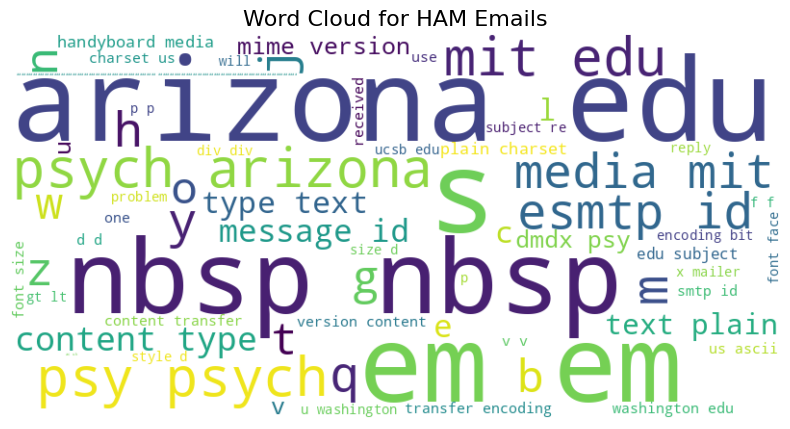

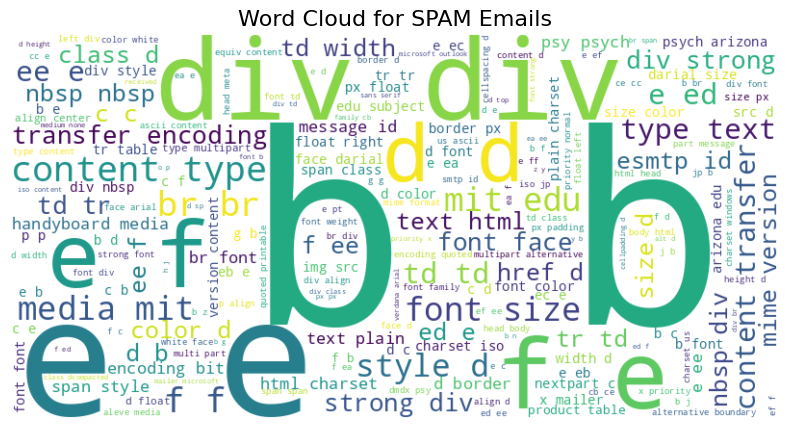

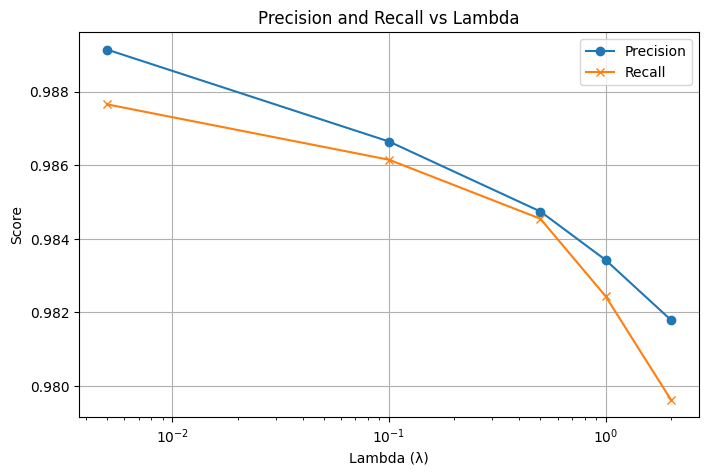

In [ ]:
# --- Load Labels and Emails ---
label_path = '/content/trec06p/trec06p-cs280/labels'
email_path = '/content/trec06p/trec06p-cs280/data'

labels = parse_labels(label_path)
df = parse_emails(email_path, labels)

# --- Basic Data Info ---
print(f"\n Total emails loaded: {len(df)}")
print("Label counts:")
print(df['label'].value_counts().rename({0: "Spam (0)", 1: "Ham (1)"}))

# --- Sort by document number for consistency ---
df['doc_num'] = df['doc_id'].str.extract(r'(\d+)', expand=False)
df = df.dropna(subset=['doc_num'])  # Drop if doc_num is NaN
df['doc_num'] = df['doc_num'].astype(int)
df = df.sort_values(by='doc_num').reset_index(drop=True)

# --- Sample data preview ---
print("\n Sample loaded emails:")
print(df[['doc_id', 'label']].head())

# --- Train/Test Split ---
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.4, stratify=df['label'], random_state=42)

print("\n Training Set Label Distribution:")
print(train_df['label'].value_counts().rename({0: "Spam (0)", 1: "Ham (1)"}))
print("\n Test Set Label Distribution:")
print(test_df['label'].value_counts().rename({0: "Spam (0)", 1: "Ham (1)"}))

# --- Train Final Model with Best Lambda ---
print("\n Training final model with best lambda (λ = 0.005)...")
model = NaiveBayesClassifier(lambda_value=0.005)
model.train(train_df)
precision, recall = model.evaluate(test_df)

print(f" Final Model Performance:")
print(f"   - Precision: {precision:.4f}")
print(f"   - Recall   : {recall:.4f}")

# --- Lambda Tuning ---
print("\n Testing different lambda values:")
results = test_lambdas(train_df, test_df)

# --- Top Informative Words ---
print("\n Top 200 Most Informative Words:")
top_words = find_most_informative_words(model, top_n=200)
print(top_words[:20])  # Show only the top 20 in the console

# --- Plot Precision and Recall vs Lambda ---
print("\n Plotting Precision and Recall vs Lambda...")
lambdas, precisions, recalls = zip(*results)

# --- Word Cloud Visualizations ---
print("\n Generating Word Clouds...")

generate_wordcloud(df, label=1, title='Word Cloud for HAM Emails')
generate_wordcloud(df, label=0, title='Word Cloud for SPAM Emails')


plt.figure(figsize=(8, 5))
plt.plot(lambdas, precisions, marker='o', label='Precision')
plt.plot(lambdas, recalls, marker='x', label='Recall')
plt.xlabel('Lambda (λ)')
plt.ylabel('Score')
plt.title('Precision and Recall vs Lambda')
plt.xscale('log')
plt.grid(True)
plt.legend()
plt.show()
